# Compare Leakage Models in a Single Attack

In the previous notebook, we compared just the models. Here we look at the impact of the model by looking at the attack outcome.

Namely, we plug in different leakage models (obtained in earlier steps) into the Pearson's correlation distinguisher. This distinguisher is classically applied in Correlation Power Analysis (CPA) with the Hamming weight model. But nothing prevents us from plugging in other, hopefully more precise, leakage models.

Here we will run a single experiment. While giving an indication and an illustration of effectiveness, statistically it provides just a single sample. In the next notebook, we will use a proper metric (success rate) obtained from many experiments.

Part of the leakage modeling tutorial, license is GPLv3, see https://www.gnu.org/licenses/gpl-3.0.en.html<br>
Requires traces and data from [pysca toolbox](https://github.com/ikizhvatov/pysca)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Leakage models obtained in notebooks 3 (with linear regrssion) and 4 (templates). Reminder: every leakage model function here defines how an intermediate value $x$ maps into predicted leakage.

In [2]:
# 8-component leakage function; beta is a 9-element array
beta9 = np.load('results/lrmodel9_1000traces.npy') # 9 coefs, the last one being the intercept
def leakageModel_LR9(x):
    result = beta9[8]
    for i in range(0, 8):
        bit = (x >> i) & 1  # this is the definition: gi = [bit i of x]
        result += beta9[i] * bit
    return result

# Hamming weight leakage model
byteHammingWeight = np.load('../data/bytehammingweight.npy') # HW table
def leakageModel_HW(x):
    return byteHammingWeight[x]

# templates (reduced, i.e. just the mean, because correlation distinguisher does not use variance)
means = np.load('results/means1000.npy') # HW table
def leakageModel_T(x):
    return means[x]

Load attack prerequisites and traces. We read out the traces starting from trace 1000, as traces below that were used to build the models.

In [3]:
# SboxNum and SampleNum should be the same as for building the leakage models
inputRange = range(1000, 2000) # range for traces (not samples!)
SboxNum = 0
SampleNum = 1025

# load samples and data
npzfile = np.load('../traces/swaes_atmega_power.npz')
data = npzfile['data'][inputRange,SboxNum]
traces = npzfile['traces'][inputRange,SampleNum]

# known key, such that we can highlight the corresponding correlation trace
key = b'\x2b\x7e\x15\x16\x28\xae\xd2\xa6\xab\xf7\x15\x88\x09\xcf\x4f\x3c'
knownKeyByte = np.uint8(key[SboxNum])

# load AES S-Box
sbox = np.load('../data/aessbox.npy')

Attack step 1: compute leakage hypotheses for all key byte candidates and input byte values

In [4]:
# compute intermediate variable hypotheses for all the key candidates
k = np.arange(0,256, dtype='uint8')
H = np.zeros((256, len(data)), dtype='uint8')
for i in range(256):
    H[i,:] = sbox[data ^ k[i]]

# apply leakage function to intermediate variables to get leakage predictions
# we do it for all models for comparison
HL_HW = list(map(leakageModel_HW, H))
HL_LR = list(map(leakageModel_LR9, H))
HL_T  = list(map(leakageModel_T, H))

Attack step 2: correlate observed leakage to predictions. We do it for increasing nubmer of traces to obtain the evolution of the correlation values for every key candidate. Then we plot the evolution.

Note that there are no usual correlation traces to meaningfully plot: we are working with a single pont in time, so every correlation trace (for a given number of traces in the attack) has just one sample.

For the sake of simplicity, the correaltion computation here is rather inefficient.

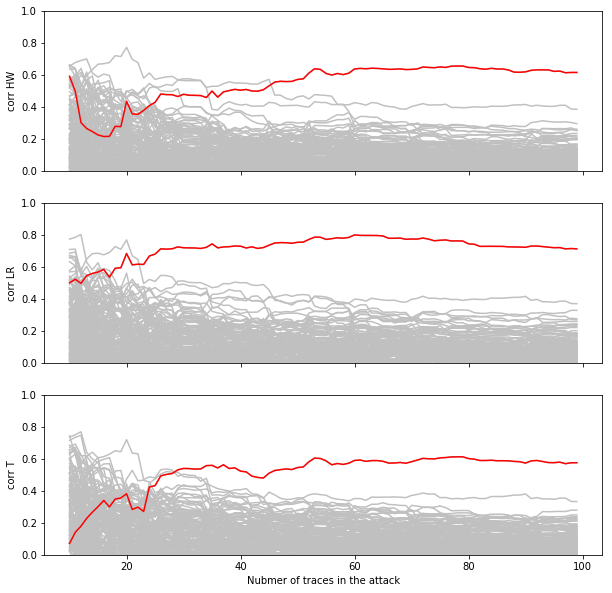

In [5]:
startTrace = 0  # trace to start with 
n = range(10,100) # trace numbers through which to run

# arrays for correlation evlution
Correlation_HW = []
Correlation_LR = []
Correlation_T = []

for i in range(256): # for each key candidate
    a = np.zeros(len(n))
    for j in range(len(n)):
        a[j] = np.corrcoef(traces[startTrace:startTrace+n[j]], HL_HW[i][startTrace:startTrace+n[j]])[0,1]
    Correlation_HW.append(a)
    
    b = np.zeros(len(n))
    for j in range(len(n)):
        b[j] = np.corrcoef(traces[startTrace:startTrace+n[j]], HL_LR[i][startTrace:startTrace+n[j]])[0,1]
    Correlation_LR.append(b)
    
    c = np.zeros(len(n))
    for j in range(len(n)):
        c[j] = np.corrcoef(traces[startTrace:startTrace+n[j]], HL_T[i][startTrace:startTrace+n[j]])[0,1]
    Correlation_T.append(c)
    
fig, (axhw, axlr, axt) = plt.subplots(3,1, sharex=True, figsize=(10, 10), squeeze=True)
for i in range(256):
    axhw.plot(n, Correlation_HW[i], color='silver')
    axlr.plot(n, Correlation_LR[i], color='silver')
    axt.plot(n, Correlation_T[i], color='silver')
axhw.plot(n, Correlation_HW[knownKeyByte], color='red') # highlihght the correct key byte candidates
axlr.plot(n, Correlation_LR[knownKeyByte], color='red')
axt.plot(n, Correlation_T[knownKeyByte], color='red')
axhw.set_ylim([0,1]) # negative value are not needed in this case
axlr.set_ylim([0,1])
axt.set_ylim([0,1])
axhw.set_ylabel("corr HW")
axlr.set_ylabel("corr LR")
axt.set_ylabel("corr T")
axt.set_xlabel("Nubmer of traces in the attack")
plt.show()

The thing to observe in the plots is the start of the separation of the correct key hypothesis from the rest. It can be seen that for leakage model built using linear regression, it starts with the least number of traces, followed by the model built using the template approach, and then goes the Hamming weight.

One could conclude that LR model is the most precise in this case. But a single experiemnt is not enough to judge. Change the start trace nubmer in the code cell above to, say, 200 and see waht happens in the plots.

In the next notebook we will comapre leakge models in terms of the attack success rate, a metric computed from many runs of the attack.